In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Set device id to 1 


# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [34]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [35]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


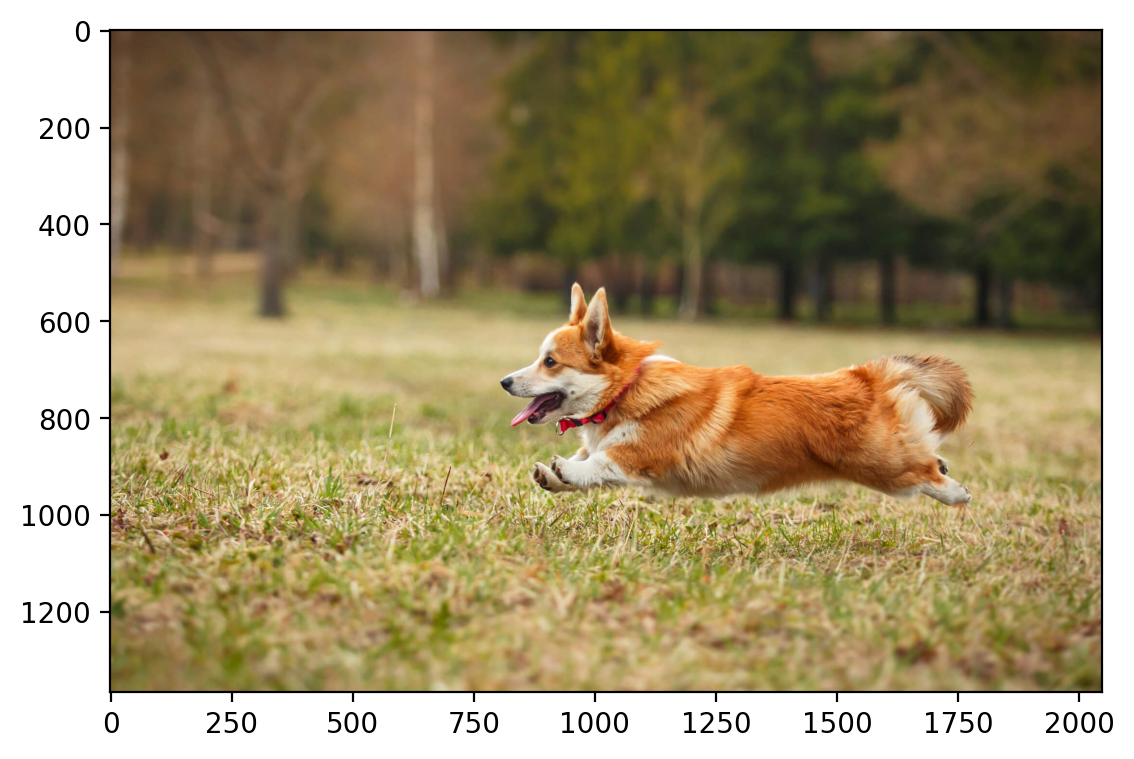

In [36]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [37]:
img,img.min(),img.max()

(tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
          [ 79,  80,  80,  ...,  75,  75,  76],
          [ 79,  80,  80,  ...,  75,  75,  76],
          ...,
          [121, 121, 122,  ...,  97,  96,  96],
          [121, 121, 122,  ...,  97,  97,  96],
          [121, 121, 122,  ...,  98,  97,  97]],
 
         [[ 52,  53,  53,  ...,  55,  55,  54],
          [ 52,  53,  53,  ...,  55,  55,  54],
          [ 52,  53,  53,  ...,  55,  55,  54],
          ...,
          [103, 103, 104,  ...,  82,  81,  81],
          [103, 103, 104,  ...,  82,  82,  81],
          [103, 103, 104,  ...,  83,  82,  82]],
 
         [[ 35,  36,  36,  ...,  30,  30,  30],
          [ 35,  36,  36,  ...,  30,  30,  30],
          [ 35,  36,  36,  ...,  30,  30,  30],
          ...,
          [ 37,  37,  38,  ...,  43,  42,  42],
          [ 37,  37,  38,  ...,  43,  43,  42],
          [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

In [38]:
# We normalize the image to be between 0 and 1
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [39]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [40]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [41]:
# Cropping the image at fixed location around the face of the dog
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

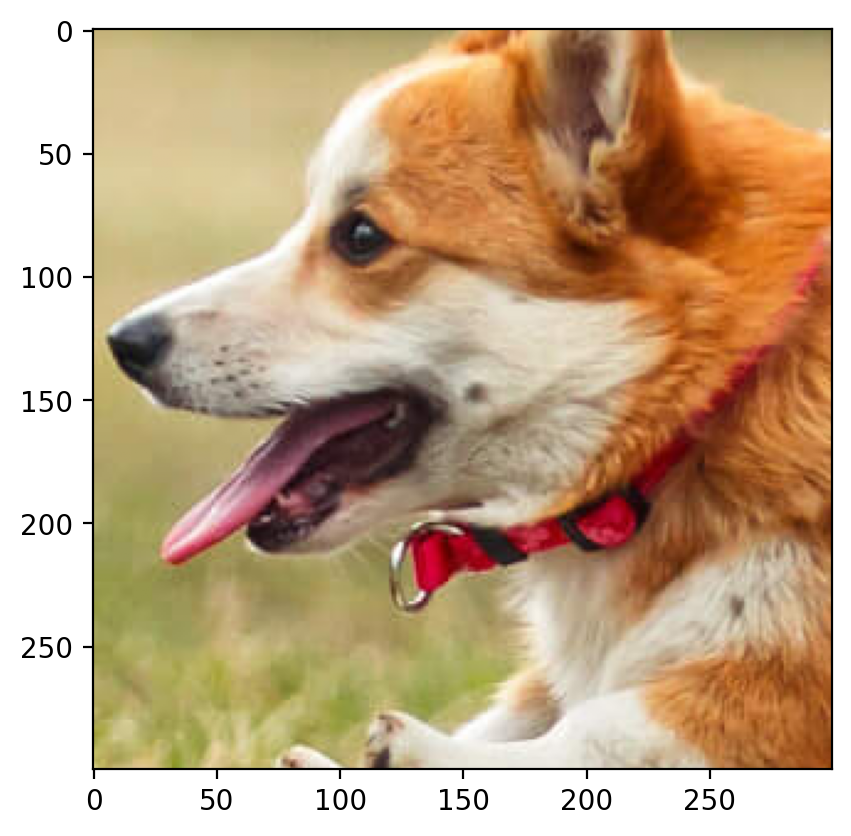

In [42]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [43]:
crop = crop.to(device)

In [44]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [45]:
# Creating a coordinate map for the image
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()
X

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [2., 3.]])

In [46]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [47]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [48]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [49]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [50]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [51]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

### Reconstruction using linear features 

In [52]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.583204
Epoch 100 loss: 0.053347
Epoch 200 loss: 0.036892
Epoch 300 loss: 0.036823
Epoch 400 loss: 0.036823
Epoch 500 loss: 0.036823
Epoch 600 loss: 0.036823
Epoch 700 loss: 0.036823
Epoch 800 loss: 0.036823
Epoch 900 loss: 0.036823


0.03682254999876022

In [53]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

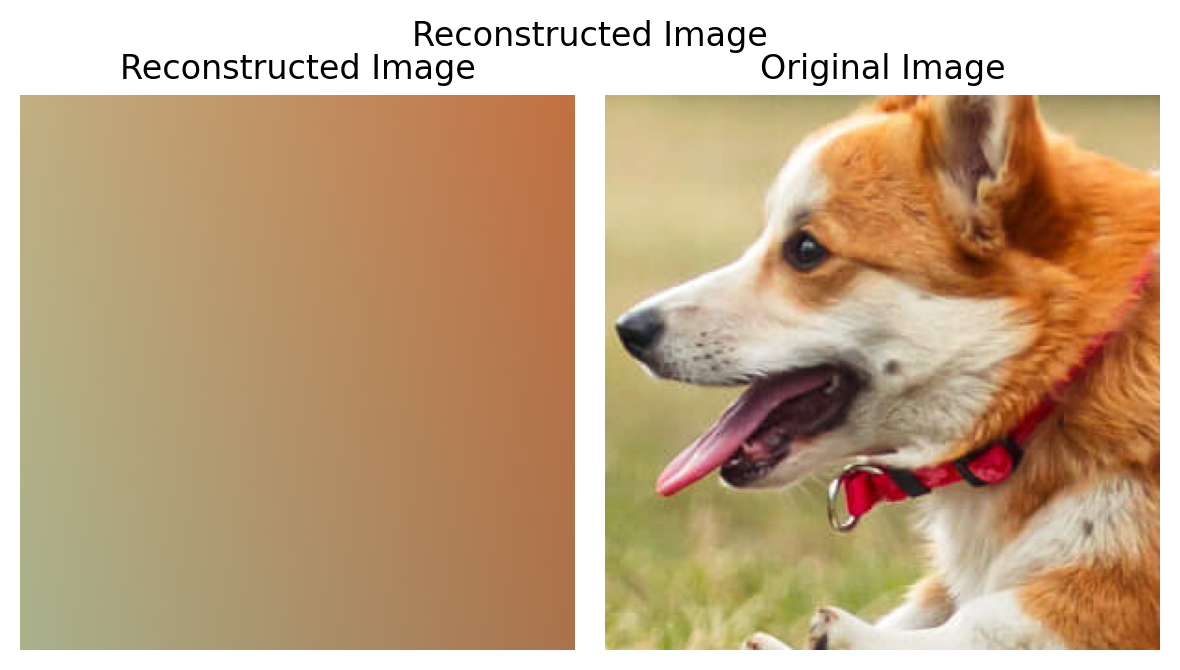

In [54]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled, title="Reconstructed Image")

### Reconstruction using polynomial features 

In [55]:
# Use polynomial features of degree "d"

def poly_features(X, degree):
    
    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())
    
    return torch.tensor(X, dtype=torch.float32).to(device)

In [56]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)

In [57]:
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, dog_Y.shape, dog_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [58]:
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, dog_X_scaled_poly, dog_Y, 1500)

Epoch 0 loss: 0.348607
Epoch 100 loss: 0.028344
Epoch 200 loss: 0.025227
Epoch 300 loss: 0.024268
Epoch 400 loss: 0.023602
Epoch 500 loss: 0.023082
Epoch 600 loss: 0.022649
Epoch 700 loss: 0.022276
Epoch 800 loss: 0.021947
Epoch 900 loss: 0.021660
Epoch 1000 loss: 0.021411
Epoch 1100 loss: 0.021174
Epoch 1200 loss: 0.020968
Epoch 1300 loss: 0.020795
Epoch 1400 loss: 0.020666


0.020457100123167038

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


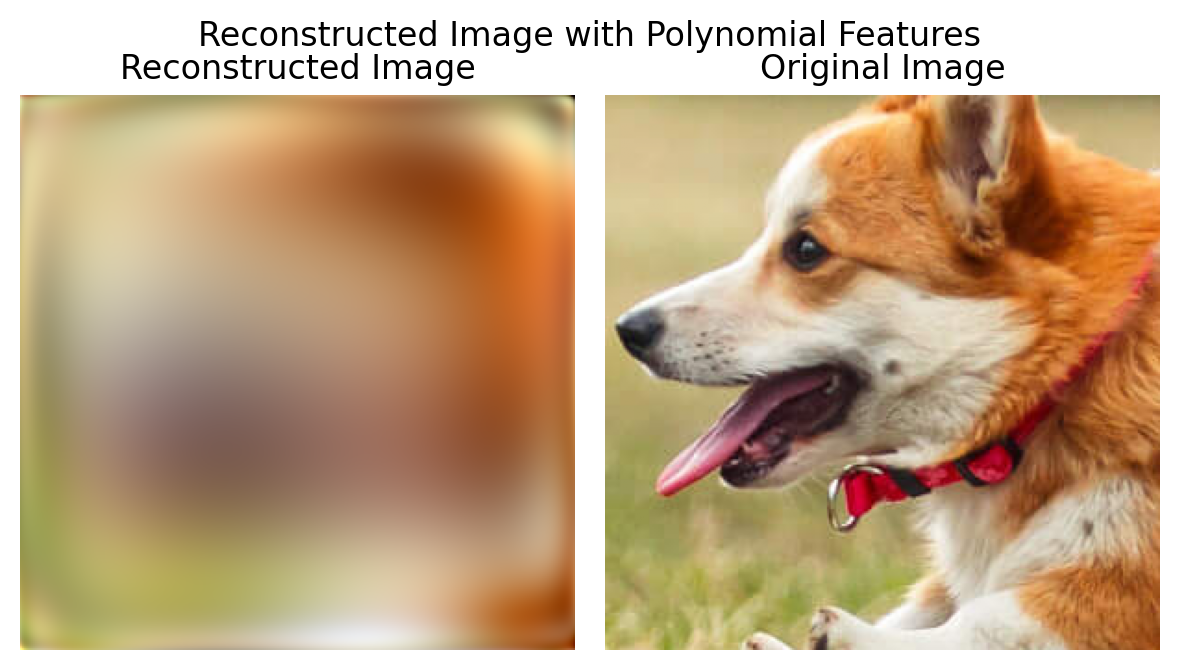

In [59]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

### Reconstruction using Random Fourier Features 

In [60]:
# create RFF features
from sklearn.kernel_approximation import RBFSampler
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [61]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [62]:
X_rff.shape

torch.Size([90000, 37500])

In [63]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.371046
Epoch 100 loss: 0.046205
Epoch 200 loss: 0.009658
Epoch 300 loss: 0.004585
Epoch 400 loss: 0.002573
Epoch 500 loss: 0.001483
Epoch 600 loss: 0.000878
Epoch 700 loss: 0.000549
Epoch 800 loss: 0.000375
Epoch 900 loss: 0.000286
Epoch 1000 loss: 0.000243
Epoch 1100 loss: 0.000222
Epoch 1200 loss: 0.000211
Epoch 1300 loss: 0.000207
Epoch 1400 loss: 0.000204
Epoch 1500 loss: 0.000202
Epoch 1600 loss: 0.000201
Epoch 1700 loss: 0.000200
Epoch 1800 loss: 0.000199
Epoch 1900 loss: 0.000199
Epoch 2000 loss: 0.000198
Epoch 2100 loss: 0.000197
Epoch 2200 loss: 0.000197
Epoch 2300 loss: 0.000196
Epoch 2400 loss: 0.000196


0.00019564952526707202

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


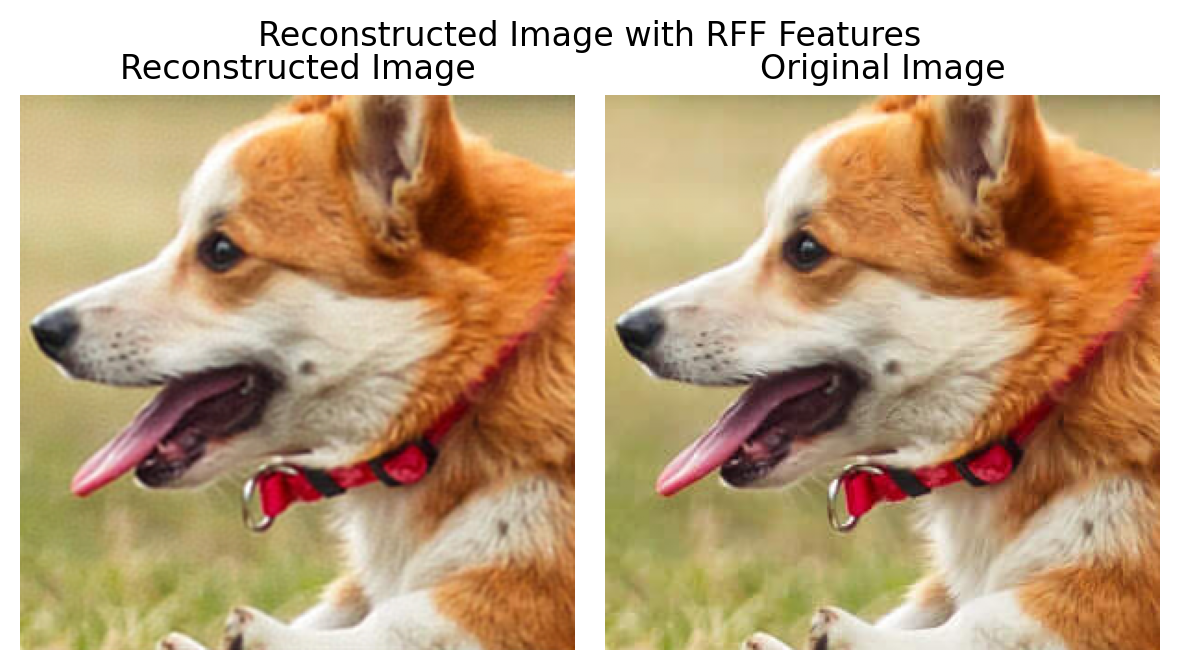

In [64]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")